# Парсинг Ведомостей

Используем расширения для Chrome для удобного парсинга http://selectorgadget.com (+ используем fromstring из либы lxml)

Будем мультипоточно качать сразу по 50 статей с сайта одновременно (Pool)

In [1]:
import pandas as pd

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
import requests
from multiprocessing.dummy import Pool
from lxml.html import fromstring

def get_page(url):
    html = requests.get(url).text
    dom = fromstring(html)
    dom.make_links_absolute(url)
    return dom

def get_article_urls(url_date):
    pattern = '.b-article__title a'
    dom = get_page(url_date)
    return [t.attrib['href'] for t in dom.cssselect(pattern)]

def get_article_text(url):
    # todo: if 'video' or 'gallery' ... - return ''
    pattern_header = 'h1'
    patterns = ['.b-news-item__text_one p', '.b-social__layout-mutation p']
    
    try:
        dom = get_page(url)
    except:
        return None, None
    
    try:
        header = dom.cssselect(pattern_header)[0].text_content().strip()
    except:
        header = ""

    try:
        css_elements = flatten([dom.cssselect(pattern) for pattern in patterns])
        text = "\n\n".join([t.text_content().strip() for t in css_elements])
    except:
        text = ""

    return header, text

flatten = lambda l: [item for sublist in l for item in sublist]

In [4]:
url_date_template = 'https://www.vedomosti.ru/archive/{}/{}/{}'
url_dates = []
for y in [2016]:
    for m in range(1,13):
        for d in range(1,29):
            url_dates.append(url_date_template.format(y,m,d))

In [5]:
pool = Pool(50)

In [6]:
%%time
url_articles = pool.map(get_article_urls, url_dates)
url_articles = flatten(url_articles)
url_articles = [url for url in url_articles if url.split('/')[4] not in {'galleries','video','online'}]

CPU times: user 42.6 s, sys: 4.54 s, total: 47.1 s
Wall time: 29.8 s


вот сколько ссылок на статьи теперь у нас есть

In [7]:
len(url_articles)

37464

ограничимся пока 10000 статьями

In [8]:
urls = url_articles[:10000]

In [9]:
df = pd.DataFrame({"url": urls})

In [10]:
df["topic"] = df.url.apply(lambda x: x.split('/')[3])
df["format"] = df.url.apply(lambda x: x.split('/')[4])

In [11]:
df.head()

,url,topic,format
0,https://www.vedomosti.ru/business/news/2016/01...,business,news
1,https://www.vedomosti.ru/politics/news/2016/01...,politics,news
2,https://www.vedomosti.ru/politics/news/2016/01...,politics,news
3,https://www.vedomosti.ru/politics/news/2016/01...,politics,news
4,https://www.vedomosti.ru/business/news/2016/01...,business,news


скачаем тексты статей

In [12]:
%%time
headers_texts = pool.map(get_article_text, urls)

CPU times: user 12min 22s, sys: 1min 46s, total: 14min 9s
Wall time: 7min 50s


In [13]:
pool.close()
pool.join()

объединим в датасет

In [14]:
df["header"] = [t[0] for t in headers_texts]
df["text"] = [t[1] for t in headers_texts]

In [15]:
df.head()

,url,topic,format,header,text
0,https://www.vedomosti.ru/business/news/2016/01...,business,news,Россия с 1 января запрещает ввоз свинины с Укр...,Россельхознадзор с 1 января вводит запрет на п...
1,https://www.vedomosti.ru/politics/news/2016/01...,politics,news,Эрдоган назвал гитлеровскую Германию примером ...,Президент Турции Тайип Эрдоган в качестве прим...
2,https://www.vedomosti.ru/politics/news/2016/01...,politics,news,Саудовская Аравия открыла посольство в Ираке с...,Саудовская Аравия спустя 25 лет открыла в стол...
3,https://www.vedomosti.ru/politics/news/2016/01...,politics,news,США и их союзники нанесли более 20 авиаударов ...,США и их союзники по антитеррористической коал...
4,https://www.vedomosti.ru/business/news/2016/01...,business,news,Экспортная пошлина на нефть в России с 1 январ...,"Экспортная пошлина на нефть в России, по данны..."


In [16]:
df.shape

(10000, 5)

In [17]:
df.to_pickle('vedomosti_archive.pkl')

длина заголовка

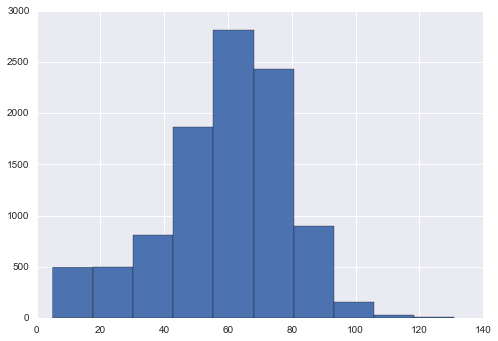

In [18]:
df.header.apply(len).hist()

длина текста

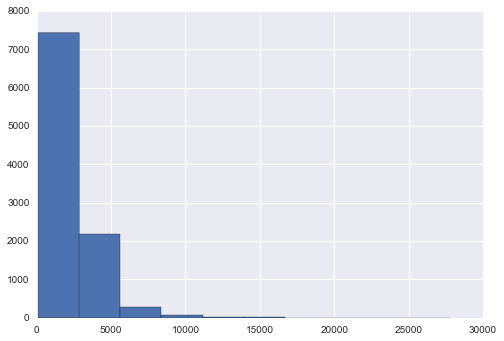

In [19]:
df.text.apply(len).hist()

длина текста, крупнее

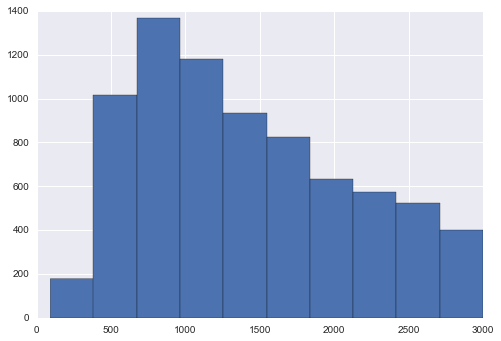

In [20]:
df[df.text.apply(len)<3000].text.apply(len).hist()

# Лемматизация слов

приведём все слова в текстах к начальной форме слова - так мы сильно сократим размерность пространства признаков

хоть pymorphy2 и достаточно быстрый, лучше его упаковывать в класс со своим кэшем (который хорошо бы ещё куда-то выгружать при окончании и загружать в начале работы, это можете доделать. Удобно для этих целей использовать json)

In [21]:
import pymorphy2
from nltk.tokenize import word_tokenize

In [23]:
class MorphProvider:
    def __init__(self):
        self.cache = {}
        self.morph = pymorphy2.MorphAnalyzer()
    
    def __call__(self, w):
        w = w.lower()
        cached = self.cache.get(w)
        if cached:
            return cached
        try:
            morphed = self.morph.parse(w)[0].normal_form
            self.cache[w] = morphed
            return morphed
        except:
            return None
    
    def morph_string(self, s):
        words = word_tokenize(s)
        return " ".join([self.__call__(w) for w in words])

In [24]:
morph = MorphProvider()

In [26]:
from tqdm import tqdm

In [27]:
df["normalized"] = [morph.morph_string(t) for t in tqdm(df.text)]

100%|██████████| 10000/10000 [00:46<00:00, 213.94it/s]


In [28]:
df.to_pickle('vedomosti_archive.pkl')

# Облако слов

*4 fun*

In [29]:
from collections import Counter

In [30]:
words = [w for w in " ".join(df.normalized).split() if len(w)>2]

In [31]:
Counter(words).most_common()[:20]

[('что', 27967),
 ('быть', 25734),
 ('это', 19756),
 ('год', 16668),
 ('компания', 15335),
 ('который', 13756),
 ('для', 11639),
 ('россия', 11541),
 ('они', 11116),
 ('миллиард', 10821),
 ('тот', 9886),
 ('рубль', 9599),
 ('2015', 9221),
 ('мочь', 9001),
 ('как', 8951),
 ('один', 8602),
 ('она', 8472),
 ('миллион', 8128),
 ('этот', 8054),
 ('весь', 7548)]

In [32]:
from wordcloud import WordCloud

def get_wordcloud(text,max_font_size=None):
    wordcloud = WordCloud(max_font_size=max_font_size).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")

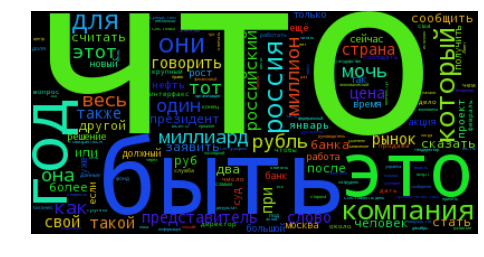

In [33]:
get_wordcloud(' '.join(words))

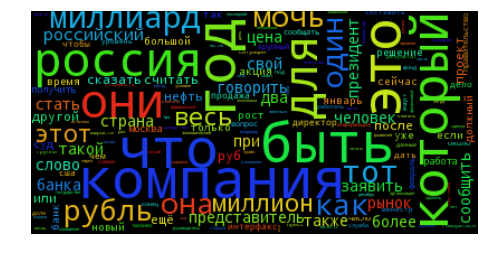

In [34]:
get_wordcloud(' '.join(words), max_font_size=50)

-----